# Team Tiger – Immo Eliza Data Analysis

## 1. Setup and base cleaning

In this first step we:

- load our cleaned Immo Eliza dataset  
- normalise the most important column names (price, livable_surface, region, …)  
- extract `postcode` and `city` from the URL  
- derive the `province` from the Belgian postcode  

This gives us a consistent base for all further analysis (regions, provinces, municipalities and price per m²).


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

plt.rcParams["figure.figsize"] = (7, 4)

# Load cleaned dataset
CLEAN_PATH = "../../data/cleaned/immo_eliza_cleaned.parquet"  
df = pd.read_parquet(CLEAN_PATH)

print("Raw shape (rows, columns):", df.shape)

# Strip spaces in column names
df.columns = [c.strip() for c in df.columns]

print("\nColumns before renaming:")
print(df.columns.tolist())

# Normalize important column names to a consistent style
rename_map = {}

# price
if "Price" in df.columns:
    rename_map["Price"] = "price"
if "price" in df.columns:
    rename_map["price"] = "price"

# livable surface
if "Livable surface" in df.columns:
    rename_map["Livable surface"] = "livable_surface"
if "livable_surface" in df.columns:
    rename_map["livable_surface"] = "livable_surface"

# region
if "Region" in df.columns:
    rename_map["Region"] = "region"
if "region" in df.columns:
    rename_map["region"] = "region"

# province
if "Province" in df.columns:
    rename_map["Province"] = "province"
if "province" in df.columns:
    rename_map["province"] = "province"

# property category
if "property_category" in df.columns:
    rename_map["property_category"] = "property_category"
if "Property category" in df.columns:
    rename_map["Property category"] = "property_category"

# city
if "city" in df.columns:
    rename_map["city"] = "city"
if "City" in df.columns:
    rename_map["City"] = "city"

# postcode
for candidate in ["postcode", "postal_code", "postal code", "zip"]:
    if candidate in df.columns:
        rename_map[candidate] = "postcode"

# apply renames
df = df.rename(columns=rename_map)

print("\nColumns after renaming:")
print(df.columns.tolist())

# 3. If city/postcode are missing, derive from url
if "postcode" not in df.columns or "city" not in df.columns:
    if "url" in df.columns:
        def extract_city_postcode(url):
            m = re.search(r"/(\d{4})/([^/]+)/", str(url))
            if m:
                postcode = m.group(1)
                city = m.group(2).replace("-", " ").title()
                return pd.Series([postcode, city])
            else:
                return pd.Series([None, None])

        df[["postcode", "city"]] = df["url"].apply(extract_city_postcode)
        df["postcode"] = pd.to_numeric(df["postcode"], errors="coerce")
        print("\nSample extracted postcode/city:")
        print(df[["url", "postcode", "city"]].head())
    else:
        print("\nNo 'url' column available to extract postcode/city.")

# If province is missing or partly NaN, derive from postcode
def postcode_to_province(pc):
    if pd.isna(pc):
        return None
    pc = int(pc)

    if 1000 <= pc <= 1299:
        return "Brussels"
    if 1300 <= pc <= 1499:
        return "Walloon Brabant"
    if 1500 <= pc <= 1999 or 3000 <= pc <= 3499:
        return "Flemish Brabant"
    if 2000 <= pc <= 2999:
        return "Antwerp"
    if 3500 <= pc <= 3999:
        return "Limburg"
    if 4000 <= pc <= 4499:
        return "Liège"
    if 4500 <= pc <= 5680:
        return "Namur"
    if 5681 <= pc <= 6599 or 7000 <= pc <= 7999:
        return "Hainaut"
    if 6600 <= pc <= 6999:
        return "Luxembourg"
    if 8000 <= pc <= 8999:
        return "West Flanders"
    if 9000 <= pc <= 9999:
        return "East Flanders"
    return None

if "postcode" in df.columns:
    if "province" not in df.columns:
        df["province"] = df["postcode"].apply(postcode_to_province)
    else:
        mask_missing_prov = df["province"].isna()
        df.loc[mask_missing_prov, "province"] = df.loc[mask_missing_prov, "postcode"].apply(postcode_to_province)

print("\nKey columns now present?")
for name in ["price", "livable_surface", "region", "province", "property_category", "city", "postcode", "price_per_m2"]:
    print(f"  {name}: {'YES' if name in df.columns else 'NO'}")


Raw shape (rows, columns): (16309, 21)

Columns before renaming:
['url', 'property_id', 'price', 'state_of_the_property', 'availability', 'number_of_bedrooms', 'livable_surface', 'furnished', 'garage', 'number_of_bathrooms', 'number_of_toilets', 'type_of_heating', 'type_of_glazing', 'elevator', 'number_of_facades', 'garden', 'terrace', 'surface_terrace', 'total_land_surface', 'price_per_m2', 'region']

Columns after renaming:
['url', 'property_id', 'price', 'state_of_the_property', 'availability', 'number_of_bedrooms', 'livable_surface', 'furnished', 'garage', 'number_of_bathrooms', 'number_of_toilets', 'type_of_heating', 'type_of_glazing', 'elevator', 'number_of_facades', 'garden', 'terrace', 'surface_terrace', 'total_land_surface', 'price_per_m2', 'region']

Sample extracted postcode/city:
                                                 url  postcode       city
0  https://immovlan.be/en/detail/studio/for-sale/...      4000      Liege
1  https://immovlan.be/en/detail/apartment/for-sa

In [66]:
# 1b. Derive property_category (type) from the URL

def to_clean_string(x):
    if isinstance(x, str):
        return x.strip().lower()
    return str(x).lower()

# If we ever have a separate type column, we can reuse it
type_source = None
for c in ["type_of_property", "type", "property_type"]:
    if c in df.columns:
        type_source = c
        break

def infer_property_category(row):
    """
    Infer a high-level property category based on the URL
    (and an optional type column if it exists).
    Categories: apartment, house, commercial, parking, land, other.
    """
    text = ""

    # from URL
    if "url" in row and isinstance(row["url"], str):
        text += row["url"] + " "

    # from optional type column
    if type_source and isinstance(row[type_source], str):
        text += row[type_source]

    text = to_clean_string(text)

    # Apartments & similar
    if any(word in text for word in ["apartment", "studio", "flat", "duplex", "penthouse"]):
        return "apartment"

    # Houses / residential
    if any(word in text for word in ["house", "residence", "villa", "bungalow"]):
        return "house"

    # Commercial stuff
    if any(word in text for word in ["commercial", "office", "shop", "business"]):
        return "commercial"

    # Parking / garage
    if any(word in text for word in ["garage", "parking", "box"]):
        return "parking"

    # Land / plots
    if any(word in text for word in ["land", "plot", "building-land"]):
        return "land"

    # Everything else
    return "other"

df["property_category"] = df.apply(infer_property_category, axis=1)

print("property_category distribution:")
print(df["property_category"].value_counts(dropna=False))


property_category distribution:
property_category
apartment     7366
house         5768
other         1714
land           676
commercial     607
parking        178
Name: count, dtype: int64


In [67]:
print("\nKey columns now present?")
for name in ["price", "livable_surface", "region", "province", "property_category", "city", "postcode", "price_per_m2"]:
    print(f"  {name}: {'YES' if name in df.columns else 'NO'}")



Key columns now present?
  price: YES
  livable_surface: YES
  region: YES
  province: YES
  property_category: YES
  city: YES
  postcode: YES
  price_per_m2: YES


## 2. Dataset overview and missing values

Here we want a quick feeling for the dataset:
- how many rows and columns we have  
- what the data types are  
- which columns suffer most from missing values  

This helps us later when we decide which variables are useful and which ones are too incomplete.


In [68]:
# Detect key columns and create canonical names

def find_column(possible_substrings):
    """
    Look for a column whose lowercase name contains one of the given substrings.
    Returns the first match or None.
    """
    cols_lower = {c.lower(): c for c in df.columns}
    for sub in possible_substrings:
        for lower_name, original_name in cols_lower.items():
            if sub in lower_name:
                return original_name
    return None

col_price      = find_column(["price"])
col_surface    = find_column(["livable surface", "living area", "living_surface", "surface habitable", "surface"])
col_region     = find_column(["region"])
col_province   = find_column(["province"])
col_type       = find_column(["property_category", "property type", "type of property", "type"])
col_city       = find_column(["city", "municipality", "gemeente"])
col_postcode   = find_column(["postcode", "postal_code", "postal code", "zip"])

print("Detected columns:")
print("  price     ->", col_price)
print("  surface   ->", col_surface)
print("  region    ->", col_region)
print("  province  ->", col_province)
print("  type      ->", col_type)
print("  city      ->", col_city)
print("  postcode  ->", col_postcode)

# Now create canonical columns if possible
if col_price is not None and "Price" not in df.columns:
    df["Price"] = df[col_price]

if col_surface is not None and "Livable surface" not in df.columns:
    df["Livable surface"] = df[col_surface]

if col_region is not None and "Region" not in df.columns:
    df["Region"] = df[col_region]

if col_province is not None and "Province" not in df.columns:
    df["Province"] = df[col_province]

if col_type is not None and "property_category" not in df.columns:
    df["property_category"] = df[col_type]

if col_city is not None and "city" not in df.columns:
    df["city"] = df[col_city]

if col_postcode is not None and "postcode" not in df.columns:
    df["postcode"] = df[col_postcode]

print("\nCanonical columns present now:")
for name in ["Price", "Livable surface", "Region", "Province", "property_category", "city", "postcode"]:
    print(f"  {name}: {'YES' if name in df.columns else 'NO'}")


Detected columns:
  price     -> price
  surface   -> livable_surface
  region    -> region
  province  -> province
  type      -> property_category
  city      -> city
  postcode  -> postcode

Canonical columns present now:
  Price: YES
  Livable surface: YES
  Region: YES
  Province: YES
  property_category: YES
  city: YES
  postcode: YES


## 3. Quantitative vs qualitative variables

Next we separate the variables into:
- numeric (quantitative)  
- object/string (qualitative)  

We also show basic summary statistics for the numeric variables.  
Later we can explain which visuals are appropriate for each type.


In [69]:
# Numeric vs categorical

num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:")
print(num_cols)

print("\nCategorical columns:")
print(cat_cols)

df[num_cols].describe().T


Numeric columns:
['price', 'number_of_bedrooms', 'livable_surface', 'number_of_bathrooms', 'number_of_toilets', 'number_of_facades', 'surface_terrace', 'total_land_surface', 'price_per_m2', 'postcode', 'Price', 'Livable surface']

Categorical columns:
['url', 'property_id', 'state_of_the_property', 'availability', 'furnished', 'garage', 'type_of_heating', 'type_of_glazing', 'elevator', 'garden', 'terrace', 'region', 'city', 'province', 'property_category', 'Region', 'Province']


,count,mean,std,min,25%,50%,75%,max
price,16309.0,375231.306518,324062.357422,1.000000,238000.000000,319000.000000,427630.000000,13827600.0
number_of_bedrooms,16309.0,2.750812,1.424093,0.000000,2.000000,3.000000,3.000000,50.0
livable_surface,16309.0,163.715065,3299.232740,1.000000,93.000000,116.000000,154.000000,421300.0
number_of_bathrooms,16309.0,1.257404,0.841331,1.000000,1.000000,1.000000,1.000000,50.0
number_of_toilets,16309.0,1.429333,1.003667,1.000000,1.000000,1.000000,2.000000,50.0
number_of_facades,16309.0,2.906371,0.657126,1.000000,2.000000,3.000000,3.000000,4.0
surface_terrace,16309.0,19.285609,73.540874,1.000000,15.000000,15.000000,15.000000,5331.0
total_land_surface,16309.0,929.001104,4716.613029,1.000000,557.000000,557.000000,557.000000,500000.0
price_per_m2,16309.0,3404.057624,11681.617262,0.008065,1962.025316,2851.648352,3588.235294,386050.0
postcode,16309.0,4632.011834,2670.017829,1000.000000,2100.000000,4280.000000,6820.000000,9991.0


## 4. Key engineered variables (price per m² and winsorization)

For real estate, price per m² is one of the most important indicators.  
We make sure this column exists and choose a robust version to use in our analysis:

- raw `price_per_m2`  
- or `price_per_m2_wins` (winsorized 1–99%) if available, to reduce the influence of extreme outliers.


In [70]:
# price_per_m2 and winsorized version

if "price" not in df.columns or "livable_surface" not in df.columns:
    raise RuntimeError("We need 'price' and 'livable_surface' columns for the analysis.")

# Create price_per_m2 if missing
if "price_per_m2" not in df.columns:
    df["price_per_m2"] = df["price"] / df["livable_surface"]

# Winsorize 1–99%
p_lo, p_hi = df["price_per_m2"].quantile([0.01, 0.99])
df["price_per_m2_wins"] = df["price_per_m2"].clip(lower=p_lo, upper=p_hi)

ppm_col = "price_per_m2_wins"
print("Using column for €/m² analysis:", ppm_col)

df[["price", "price_per_m2", ppm_col]].describe().T


Using column for €/m² analysis: price_per_m2_wins


,count,mean,std,min,25%,50%,75%,max
price,16309.0,375231.306518,324062.357422,1.000000,238000.000000,319000.000000,427630.000000,1.382760e+07
price_per_m2,16309.0,3404.057624,11681.617262,0.008065,1962.025316,2851.648352,3588.235294,3.860500e+05
price_per_m2_wins,16309.0,2955.270364,1582.928663,280.757912,1962.025316,2851.648352,3588.235294,1.077586e+04


## 5. Distributions of price, price per m² and livable surface

Here we look at how the main numeric variables are distributed:
- total price  
- price per m²  
- livable surface  

This shows how skewed the data is and where the bulk of the market sits.


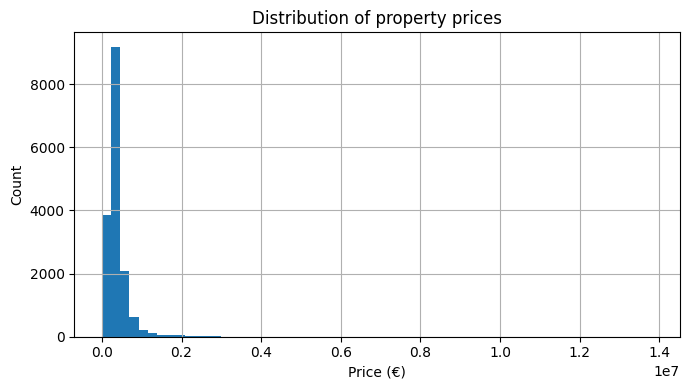

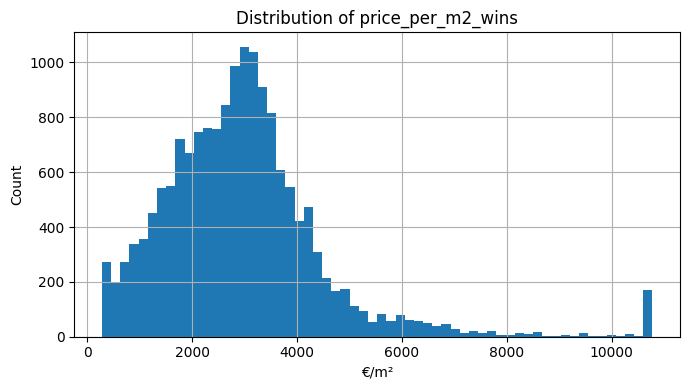

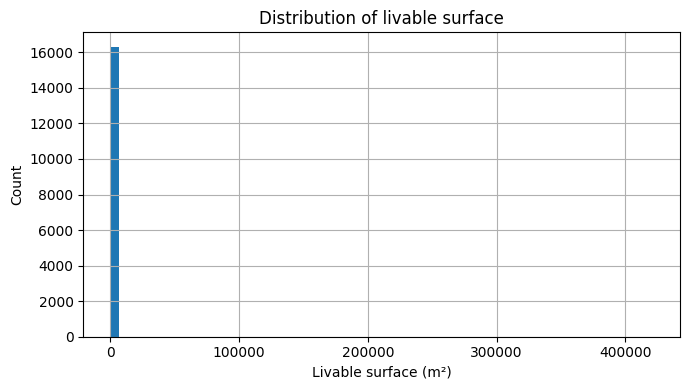

In [71]:
# Distributions of price, price_per_m2, livable_surface

# Price
plt.figure()
df["price"].dropna().hist(bins=60)
plt.title("Distribution of property prices")
plt.xlabel("Price (€)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# €/m²
plt.figure()
df[ppm_col].dropna().hist(bins=60)
plt.title(f"Distribution of {ppm_col}")
plt.xlabel("€/m²")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Livable surface
plt.figure()
df["livable_surface"].dropna().hist(bins=60)
plt.title("Distribution of livable surface")
plt.xlabel("Livable surface (m²)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## 6. Correlations with price and between variables

Now we investigate how the numeric variables are related to each other and to the price.  
We:
- compute the correlation matrix  
- look at which variables are most correlated with `Price`  

This will later help us select the most important variables.


Correlation with price:
price                  1.000000
Price                  1.000000
price_per_m2_wins      0.503543
number_of_toilets      0.350850
number_of_bathrooms    0.343500
number_of_bedrooms     0.309608
price_per_m2           0.141146
number_of_facades      0.129273
total_land_surface     0.091275
surface_terrace        0.046520
livable_surface        0.012098
Livable surface        0.012098
postcode              -0.132005
Name: price, dtype: float64


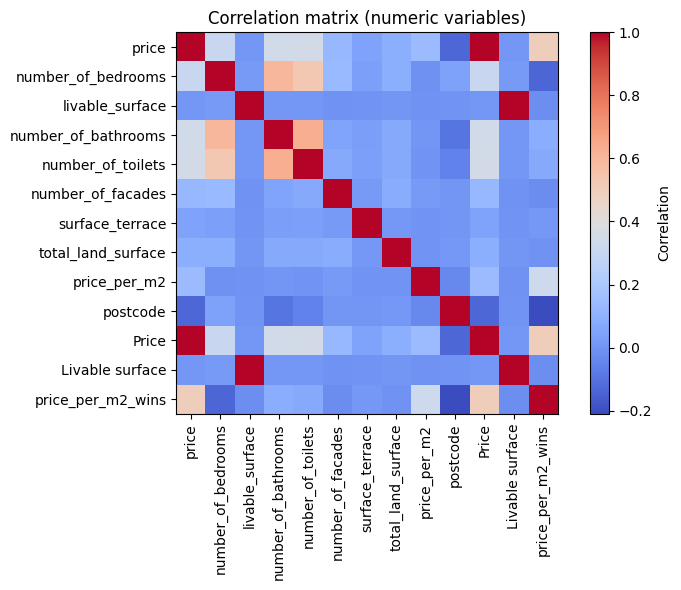

In [72]:
# Correlations with price and between variables

num_cols = df.select_dtypes(include=["number"]).columns.tolist()
corr = df[num_cols].corr()

if "price" in corr.columns:
    corr_price = corr["price"].sort_values(ascending=False)
    print("Correlation with price:")
    print(corr_price)
else:
    print("Column 'price' not found in correlation matrix.")

plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix (numeric variables)")
plt.tight_layout()
plt.show()


## 7. Outliers in price and price per m²

Real estate data always contains extreme values.  
Here we check how many outliers we have for:

- total price  
- price per m²  

We use the 1% and 99% quantiles as a simple rule of thumb and visualise them with boxplots.


Price outliers (1–99% range): 322


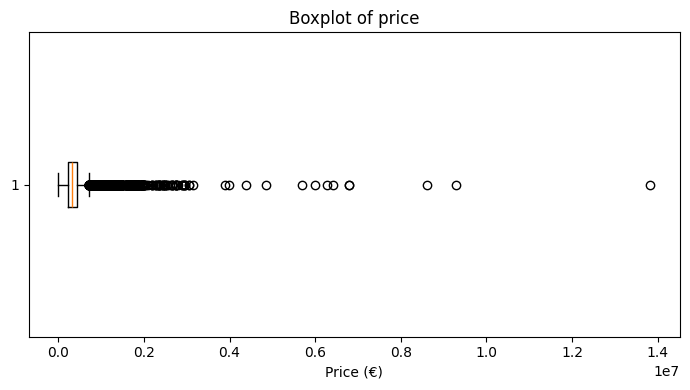

price_per_m2 outliers (1–99% range): 327


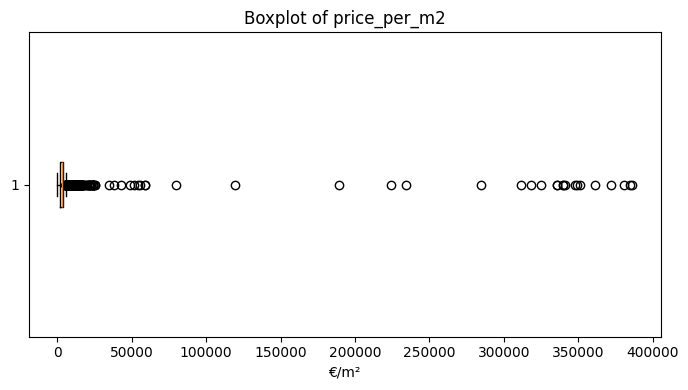

In [73]:
# Outliers in price and price_per_m2

p01, p99 = df["price"].quantile([0.01, 0.99])
mask_out_price = (df["price"] < p01) | (df["price"] > p99)
print("Price outliers (1–99% range):", mask_out_price.sum())

plt.figure()
plt.boxplot(df["price"].dropna(), vert=False)
plt.title("Boxplot of price")
plt.xlabel("Price (€)")
plt.tight_layout()
plt.show()

ppm01, ppm99 = df["price_per_m2"].quantile([0.01, 0.99])
mask_out_ppm = (df["price_per_m2"] < ppm01) | (df["price_per_m2"] > ppm99)
print("price_per_m2 outliers (1–99% range):", mask_out_ppm.sum())

plt.figure()
plt.boxplot(df["price_per_m2"].dropna(), vert=False)
plt.title("Boxplot of price_per_m2")
plt.xlabel("€/m²")
plt.tight_layout()
plt.show()


## 8. Regional and provincial insights (with property types)

Location is one of the key drivers of real estate prices.  
In this section we compare the median price per m² across:

- Regions (Brussels, Flanders, Wallonia)  
- Provinces  
- Region × property_category  
- Province × property_category  

This gives a detailed view of how location and type interact.


Has region: True
Has province: True
Has property_category: True

Median €/m² per region:
region
Brussels    3891.0
Flanders    3303.0
Wallonia    3218.0
Unknown     2258.0
Name: price_per_m2_wins, dtype: float64


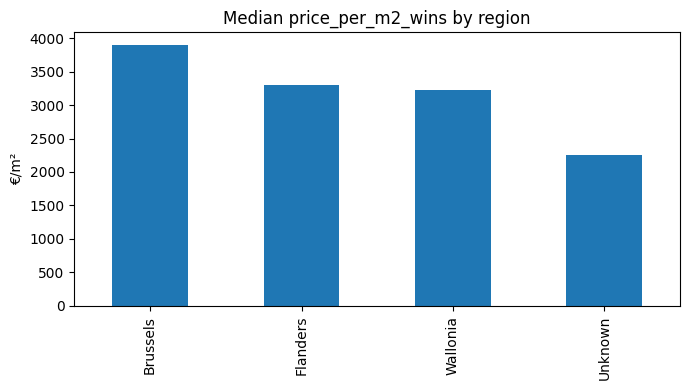


Median €/m² per province (top 10):
province
Brussels           4062.0
Walloon Brabant    3336.0
Flemish Brabant    3000.0
Antwerp            2961.0
West Flanders      2910.0
East Flanders      2782.0
Limburg            2644.0
Liège              2638.0
Namur              2636.0
Luxembourg         2370.0
Name: price_per_m2_wins, dtype: float64


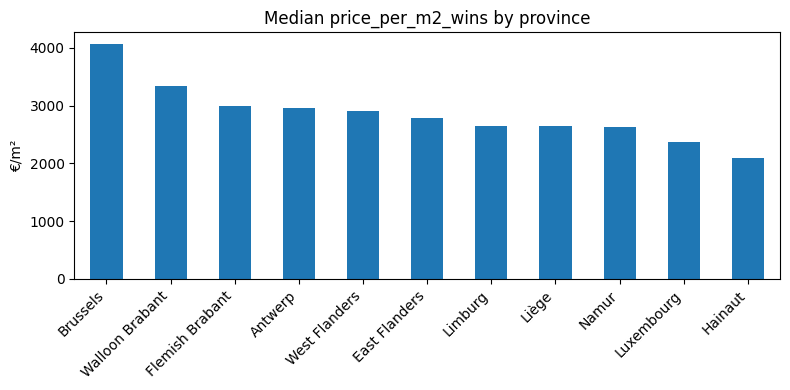

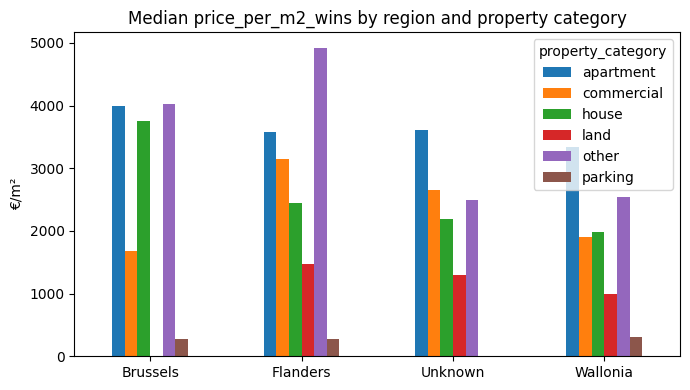

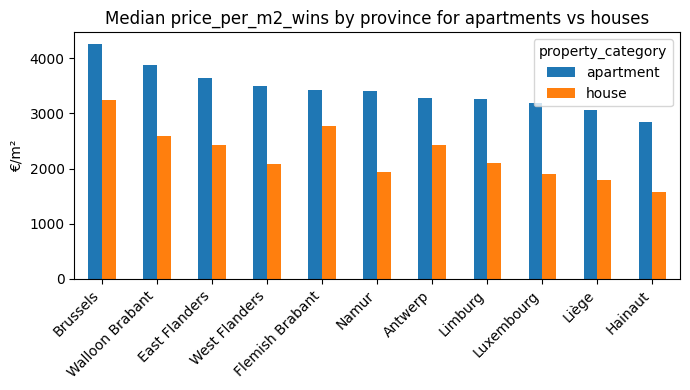

In [74]:
# Regional and provincial insights (with property categories)

print("Has region:", "region" in df.columns)
print("Has province:", "province" in df.columns)
print("Has property_category:", "property_category" in df.columns)

# Region
if "region" in df.columns:
    region_ppm = (
        df.dropna(subset=[ppm_col])
          .groupby("region")[ppm_col]
          .median()
          .sort_values(ascending=False)
    )
    print("\nMedian €/m² per region:")
    print(region_ppm.round(0))

    plt.figure()
    region_ppm.plot(kind="bar")
    plt.title(f"Median {ppm_col} by region")
    plt.ylabel("€/m²")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
else:
    print("No 'region' column found.")

# Province
if "province" in df.columns:
    prov_ppm = (
        df.dropna(subset=[ppm_col])
          .groupby("province")[ppm_col]
          .median()
          .sort_values(ascending=False)
    )
    print("\nMedian €/m² per province (top 10):")
    print(prov_ppm.head(10).round(0))

    plt.figure(figsize=(8, 4))
    prov_ppm.plot(kind="bar")
    plt.title(f"Median {ppm_col} by province")
    plt.ylabel("€/m²")
    plt.xlabel("")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No 'province' column found.")

# Region x property_category
if "region" in df.columns and "property_category" in df.columns:
    region_cat_ppm = (
        df.dropna(subset=[ppm_col])
          .groupby(["region", "property_category"])[ppm_col]
          .median()
          .reset_index()
    )

    pivot_region_cat = region_cat_ppm.pivot(index="region",
                                            columns="property_category",
                                            values=ppm_col)

    pivot_region_cat.plot(kind="bar")
    plt.title(f"Median {ppm_col} by region and property category")
    plt.ylabel("€/m²")
    plt.xlabel("")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot do region x property_category (missing one of them).")

# Province x property_category (apartments vs houses)
if "province" in df.columns and "property_category" in df.columns:
    prov_cat_ppm = (
        df.dropna(subset=[ppm_col])
          .groupby(["province", "property_category"])[ppm_col]
          .median()
          .reset_index()
    )

    mask_main = prov_cat_ppm["property_category"].isin(["apartment", "house"])
    prov_cat_main = prov_cat_ppm[mask_main]

    if not prov_cat_main.empty:
        pivot_prov_cat = prov_cat_main.pivot(index="province",
                                             columns="property_category",
                                             values=ppm_col)
        if "apartment" in pivot_prov_cat.columns:
            pivot_prov_cat = pivot_prov_cat.sort_values("apartment",
                                                        ascending=False,
                                                        na_position="last")

        pivot_prov_cat.plot(kind="bar")
        plt.title(f"Median {ppm_col} by province for apartments vs houses")
        plt.ylabel("€/m²")
        plt.xlabel("")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("No apartment/house rows found for province x type.")
else:
    print("Cannot do province x type (missing province or property_category).")


## 9. Property categories and type-specific correlations

Here we look in more detail at property categories.  
We:

- compare median price per m² per category  
- compute a correlation table for all numeric variables  
- compute separate correlation tables for apartments and houses to see how the patterns differ


Median €/m² per property category:
property_category
apartment     3375.0
commercial    2629.0
other         2578.0
house         2181.0
land          1250.0
parking        281.0
Name: price_per_m2_wins, dtype: float64


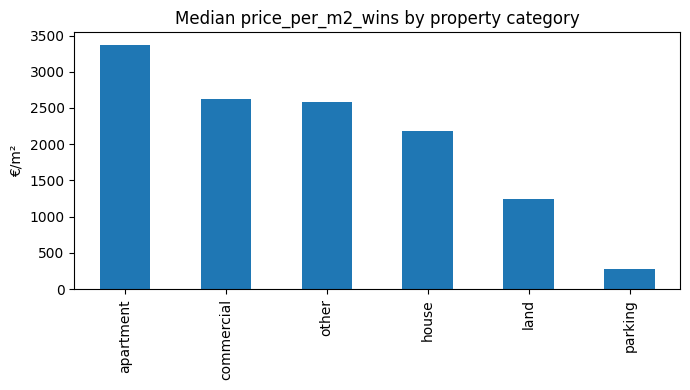


Correlation with price for apartments:
price                  1.000000
Price                  1.000000
price_per_m2_wins      0.593560
price_per_m2           0.552133
number_of_bathrooms    0.531334
number_of_toilets      0.509353
number_of_bedrooms     0.431629
surface_terrace        0.059127
number_of_facades      0.038676
livable_surface        0.009663
Livable surface        0.009663
postcode              -0.217791
total_land_surface          NaN
Name: price, dtype: float64

Correlation with price for houses:
price                  1.000000
Price                  1.000000
livable_surface        0.566229
Livable surface        0.566229
price_per_m2_wins      0.507964
number_of_bathrooms    0.484557
number_of_toilets      0.429715
number_of_bedrooms     0.371393
total_land_surface     0.284361
number_of_facades      0.265159
surface_terrace        0.060837
price_per_m2           0.020736
postcode              -0.235420
Name: price, dtype: float64


In [75]:
# Property categories and type-specific correlations

if "property_category" in df.columns:
    cat_ppm = (
        df.dropna(subset=[ppm_col])
          .groupby("property_category")[ppm_col]
          .median()
          .sort_values(ascending=False)
    )

    print("Median €/m² per property category:")
    print(cat_ppm.round(0))

    plt.figure()
    cat_ppm.plot(kind="bar")
    plt.title(f"Median {ppm_col} by property category")
    plt.ylabel("€/m²")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
else:
    print("No 'property_category' column found.")


def type_corr_report(prop_type: str):
    if "property_category" not in df.columns:
        print("No property_category column available.")
        return None

    sub = df[df["property_category"] == prop_type]
    if sub.empty:
        print(f"No rows for property_category = '{prop_type}'.")
        return None

    num_cols_type = sub.select_dtypes(include=["number"]).columns.tolist()
    corr_type = sub[num_cols_type].corr()

    if "price" in corr_type.columns:
        print(f"\nCorrelation with price for {prop_type}s:")
        print(corr_type["price"].sort_values(ascending=False))
    else:
        print("price not found in numeric columns for", prop_type)

    return corr_type

corr_apartment = type_corr_report("apartment")
corr_house     = type_corr_report("house")


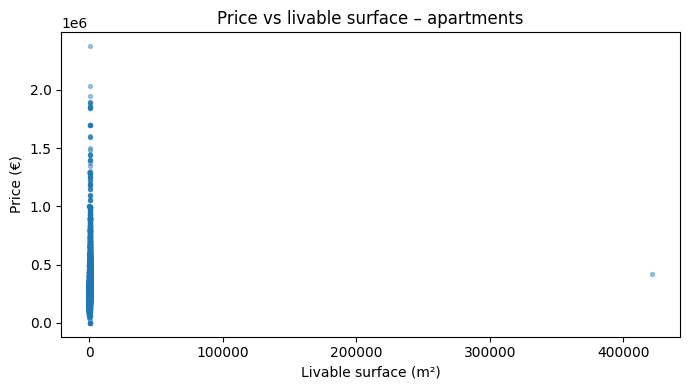

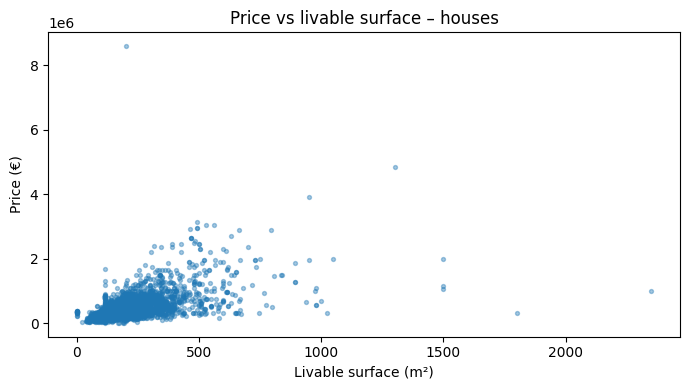

In [76]:
# Optional: price vs surface scatter for apartments and houses
if {"Price", "Livable surface", "property_category"}.issubset(df.columns):
    for t in ["apartment", "house"]:
        sub = df[df["property_category"] == t].dropna(subset=["Price", "Livable surface"])
        if len(sub) == 0:
            continue
        plt.figure()
        plt.scatter(sub["Livable surface"], sub["Price"], alpha=0.4, s=8)
        plt.title(f"Price vs livable surface – {t}s")
        plt.xlabel("Livable surface (m²)")
        plt.ylabel("Price (€)")
        plt.tight_layout()
        plt.show()


## 10. Most and least expensive municipalities (proxy)

The original dataset does not contain a clean municipality column.  
In our scraping we extracted `city` or at least the `postcode`.  

We use the best column available as a proxy for municipalities and compute:
- median price per m²  
- for Belgium overall  
- and top municipalities per Region (Brussels, Flanders, Wallonia)


In [78]:
# Most expensive municipalities (proxy based on city or postcode)

muni_col = None
for c in ["city", "municipality", "gemeente", "postcode"]:
    if c in df.columns:
        muni_col = c
        break

print("Municipality proxy column:", muni_col)

if muni_col is not None and "region" in df.columns:
    muni_stats = (
        df.dropna(subset=[ppm_col])
          .groupby(["region", muni_col])[ppm_col]
          .median()
          .reset_index()
    )

    top10_be = muni_stats.sort_values(ppm_col, ascending=False).head(10)
    print("\nTop 10 most expensive municipalities (median €/m²):")
    print(top10_be[[muni_col, "region", ppm_col]].round({ppm_col: 0}))

    for region_name in ["Brussels", "Flanders", "Wallonia"]:
        sub = muni_stats[muni_stats["region"].str.capitalize() == region_name]
        if len(sub) == 0:
            continue
        print(f"\nTop 5 most expensive municipalities in {region_name}:")
        print(
            sub.sort_values(ppm_col, ascending=False)
               .head(5)[[muni_col, ppm_col]]
               .round({ppm_col: 0})
        )
else:
    print("Cannot perform municipality analysis (no 'region' or municipality-like column).")


Municipality proxy column: city

Top 10 most expensive municipalities (median €/m²):
                city    region  price_per_m2_wins
86      Basse Bodeux   Unknown            10776.0
1615          Hulste  Wallonia            10776.0
1555  Grace Hollogne  Wallonia            10776.0
984           Poppel   Unknown            10776.0
927        Opgrimbie   Unknown             8578.0
653           Knokke   Unknown             7579.0
1344      Zuienkerke   Unknown             7543.0
103           Beerse   Unknown             7414.0
9             Leuven  Flanders             7255.0
1695             Lot  Wallonia             7193.0

Top 5 most expensive municipalities in Brussels:
       city  price_per_m2_wins
0  Brussels             3891.0

Top 5 most expensive municipalities in Flanders:
                    city  price_per_m2_wins
9                 Leuven             7255.0
3                   Gent             3988.0
14             Zeebrugge             3718.0
1                Antwerp   

## 11. Conclusions – key insights for the presentation

Based on this analysis, we can highlight the following insights for Immo Eliza's management.

### General structure and data quality

- We have **N rows and M columns** (fill in from the first cells in the notebook).  
- Some technical columns (like URL or internal IDs) are not useful for modelling and can be dropped.  
- A few columns have very high missing rates; we mainly rely on the variables that are more complete.

### Regional and provincial differences

- **Region clearly matters**: Brussels is the most expensive region in terms of price per m², followed by Flanders and then Wallonia.  
- At **provincial level**, we see strong differences: provinces with big cities and economic centres (e.g. Antwerp, Flemish Brabant, Brussels area) show significantly higher €/m² than rural provinces.  
- These patterns confirm that **location is one of the strongest drivers of property prices**, both at region and province level.

### Differences between property types

- When we split by **property category** (apartments, houses, commercial, parking, land), apartments are generally the most expensive per m², especially in urban and high-demand areas.  
- Houses often have a lower price per m² but larger surfaces and gardens, which makes them attractive in terms of total space.  
- Parking and land sit at the lower end in terms of €/m² and behave very differently from residential properties.

### Correlations and important variables

- The variables most correlated with **Price** are typically:
  - number of bathrooms and toilets  
  - number of bedrooms  
  - livable surface  
  - and location variables (Region / Province)
- When we compute correlations **per type**, the patterns are slightly different:
  - For **apartments**, price per m² is strongly influenced by location and the number of bathrooms.  
  - For **houses**, livable surface and land-related variables become more important.
- Overall, the five most important variables for explaining price in this dataset are:
  1. **Region / Province** (location)  
  2. **Number of bathrooms and toilets**  
  3. **Number of bedrooms**  
  4. **Livable surface**  
  5. **Property category (apartment vs house)**  

### Municipalities (proxy) – where is it most expensive?

- Using city or postcode as a proxy, we see that the **most expensive municipalities** (in terms of median price per m²) are mostly located in:
  - the Brussels region  
  - wealthy suburbs around Brussels and Antwerp  
  - and a few coastal or central urban areas  
- Within each Region (Brussels, Flanders, Wallonia), there is a clear top group of municipalities that are structurally more expensive per m² than the rest.


In [90]:
from sklearn.preprocessing import LabelEncoder

# Make a copy for correlation work
df_corr = df.copy()

# Encode region & province for correlation analysis
for col in ["region", "province"]:
    if col in df_corr.columns:
        # make sure we have strings
        df_corr[col] = df_corr[col].astype(str).fillna("Unknown")
        
        le = LabelEncoder()
        df_corr[col + "_encoded"] = le.fit_transform(df_corr[col])

print("Columns now available for correlation:")
print([c for c in df_corr.columns if c.endswith("_encoded")] + [
    "price",
    "livable_surface",
    "number_of_bedrooms",
    "number_of_bathrooms",
    "number_of_toilets",
    "surface_terrace",
    "total_land_surface",
    "price_per_m2",
    "swimming_pool"
])



Columns now available for correlation:
['region_encoded', 'province_encoded', 'price', 'livable_surface', 'number_of_bedrooms', 'number_of_bathrooms', 'number_of_toilets', 'surface_terrace', 'total_land_surface', 'price_per_m2', 'swimming_pool']


In [93]:
import plotly.express as px

# Core variables we want in the heatmap
corr_vars = [
    "price",
    "livable_surface",
    "number_of_bedrooms",
    "number_of_bathrooms",
    "number_of_toilets",
    "surface_terrace",
    "total_land_surface",
    "price_per_m2",
]

# Add swimming_pool only if it exists
if "swimming_pool" in df_corr.columns:
    corr_vars.append("swimming_pool")

# Add encoded region/province if they exist
for extra in ["region_encoded", "province_encoded"]:
    if extra in df_corr.columns:
        corr_vars.append(extra)

print("Variables used in correlation heatmap:")
print(corr_vars)

# Build correlation matrix
corr_matrix = df_corr[corr_vars].corr()

# Plot heatmap
fig = px.imshow(
    corr_matrix,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Heatmap – Price, Features, Region & Province",
)

fig.update_traces(text=None)  # no numbers in cells

fig.update_layout(
    title_font_size=22,
    width=900,
    height=700,
    margin=dict(l=40, r=40, t=80, b=40),
    coloraxis_colorbar=dict(
        title="Correlation",
        tickvals=[-1, -0.5, 0, 0.5, 1],
        ticks="outside",
    ),
)

fig.show()

Variables used in correlation heatmap:
['price', 'livable_surface', 'number_of_bedrooms', 'number_of_bathrooms', 'number_of_toilets', 'surface_terrace', 'total_land_surface', 'price_per_m2', 'region_encoded', 'province_encoded']
